In [22]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPool2D, Dropout, Flatten, LSTM, Dense, LeakyReLU

In [3]:
data_dir = './'
train_path = './Train/'
test_path = './Test/'
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

44

In [4]:
#Assigning Labels
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

Visualizing The Dataset

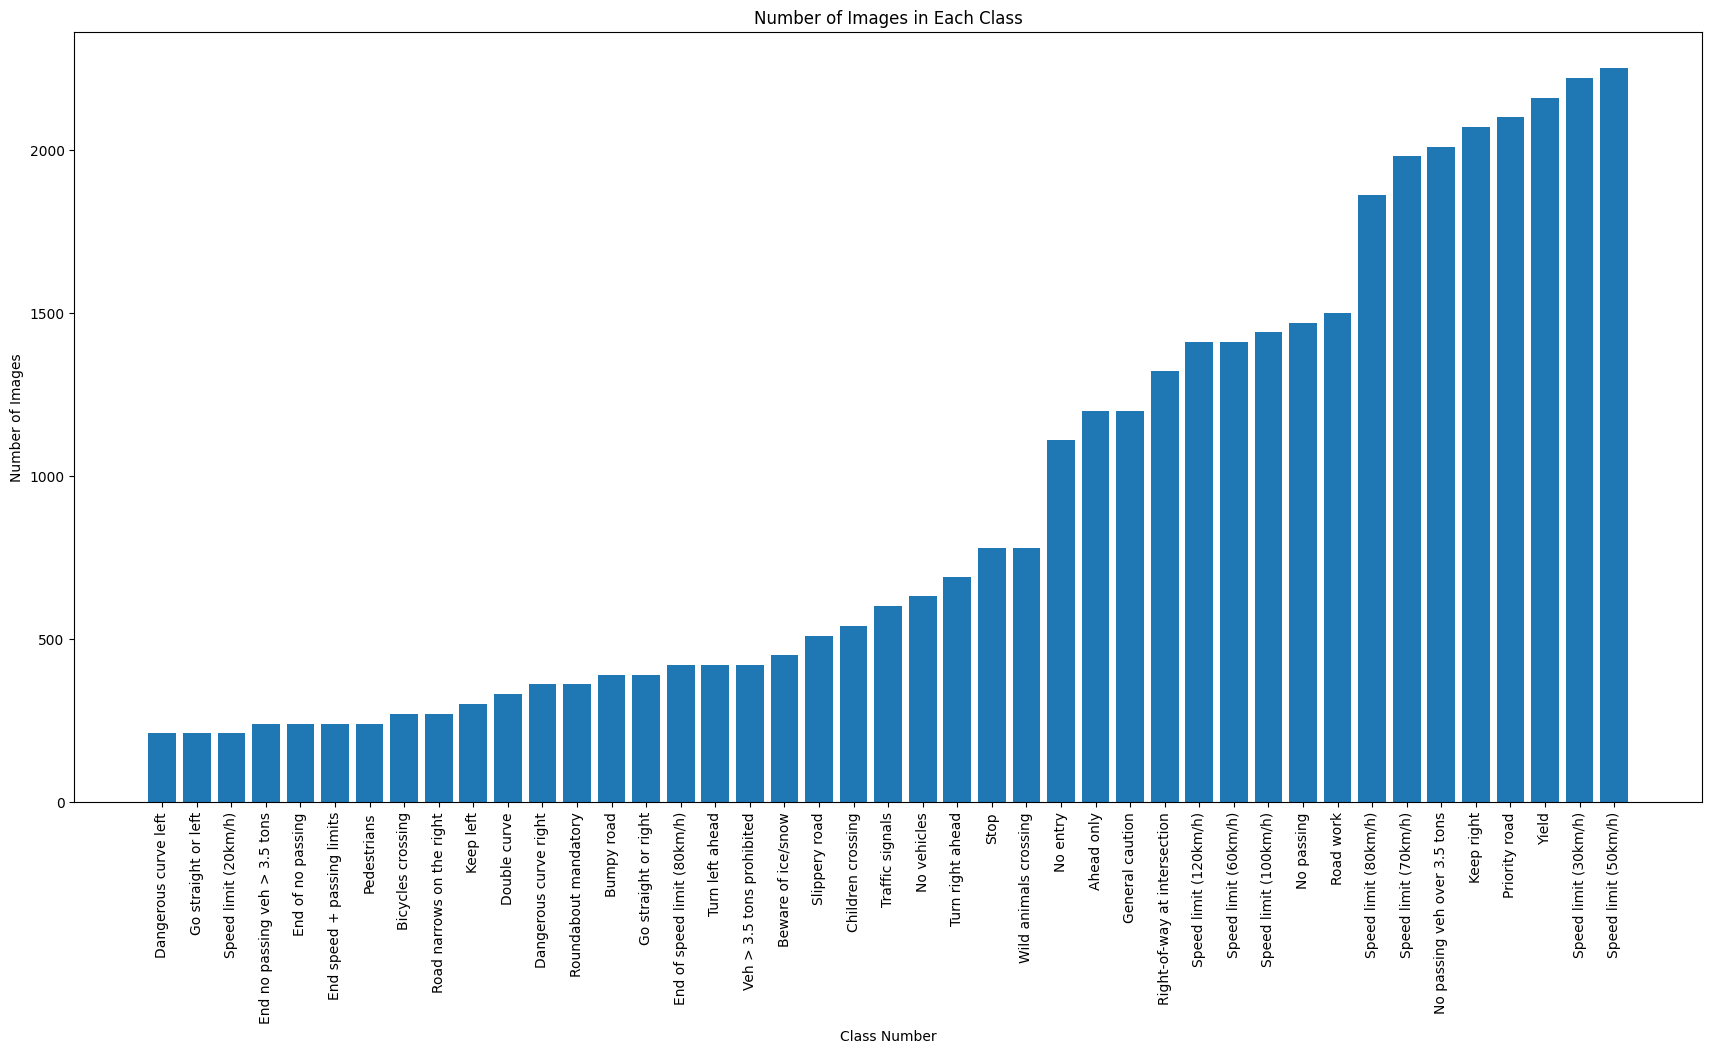

In [6]:
import os
import matplotlib.pyplot as plt

train_path = './Train'
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    folder_path = os.path.join(train_path, folder)
    
    # Skip non-directory files
    if not os.path.isdir(folder_path):
        continue
    
    train_files = os.listdir(folder_path)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [list(tuple) for tuple in tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21, 10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.xlabel('Class Number')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show()


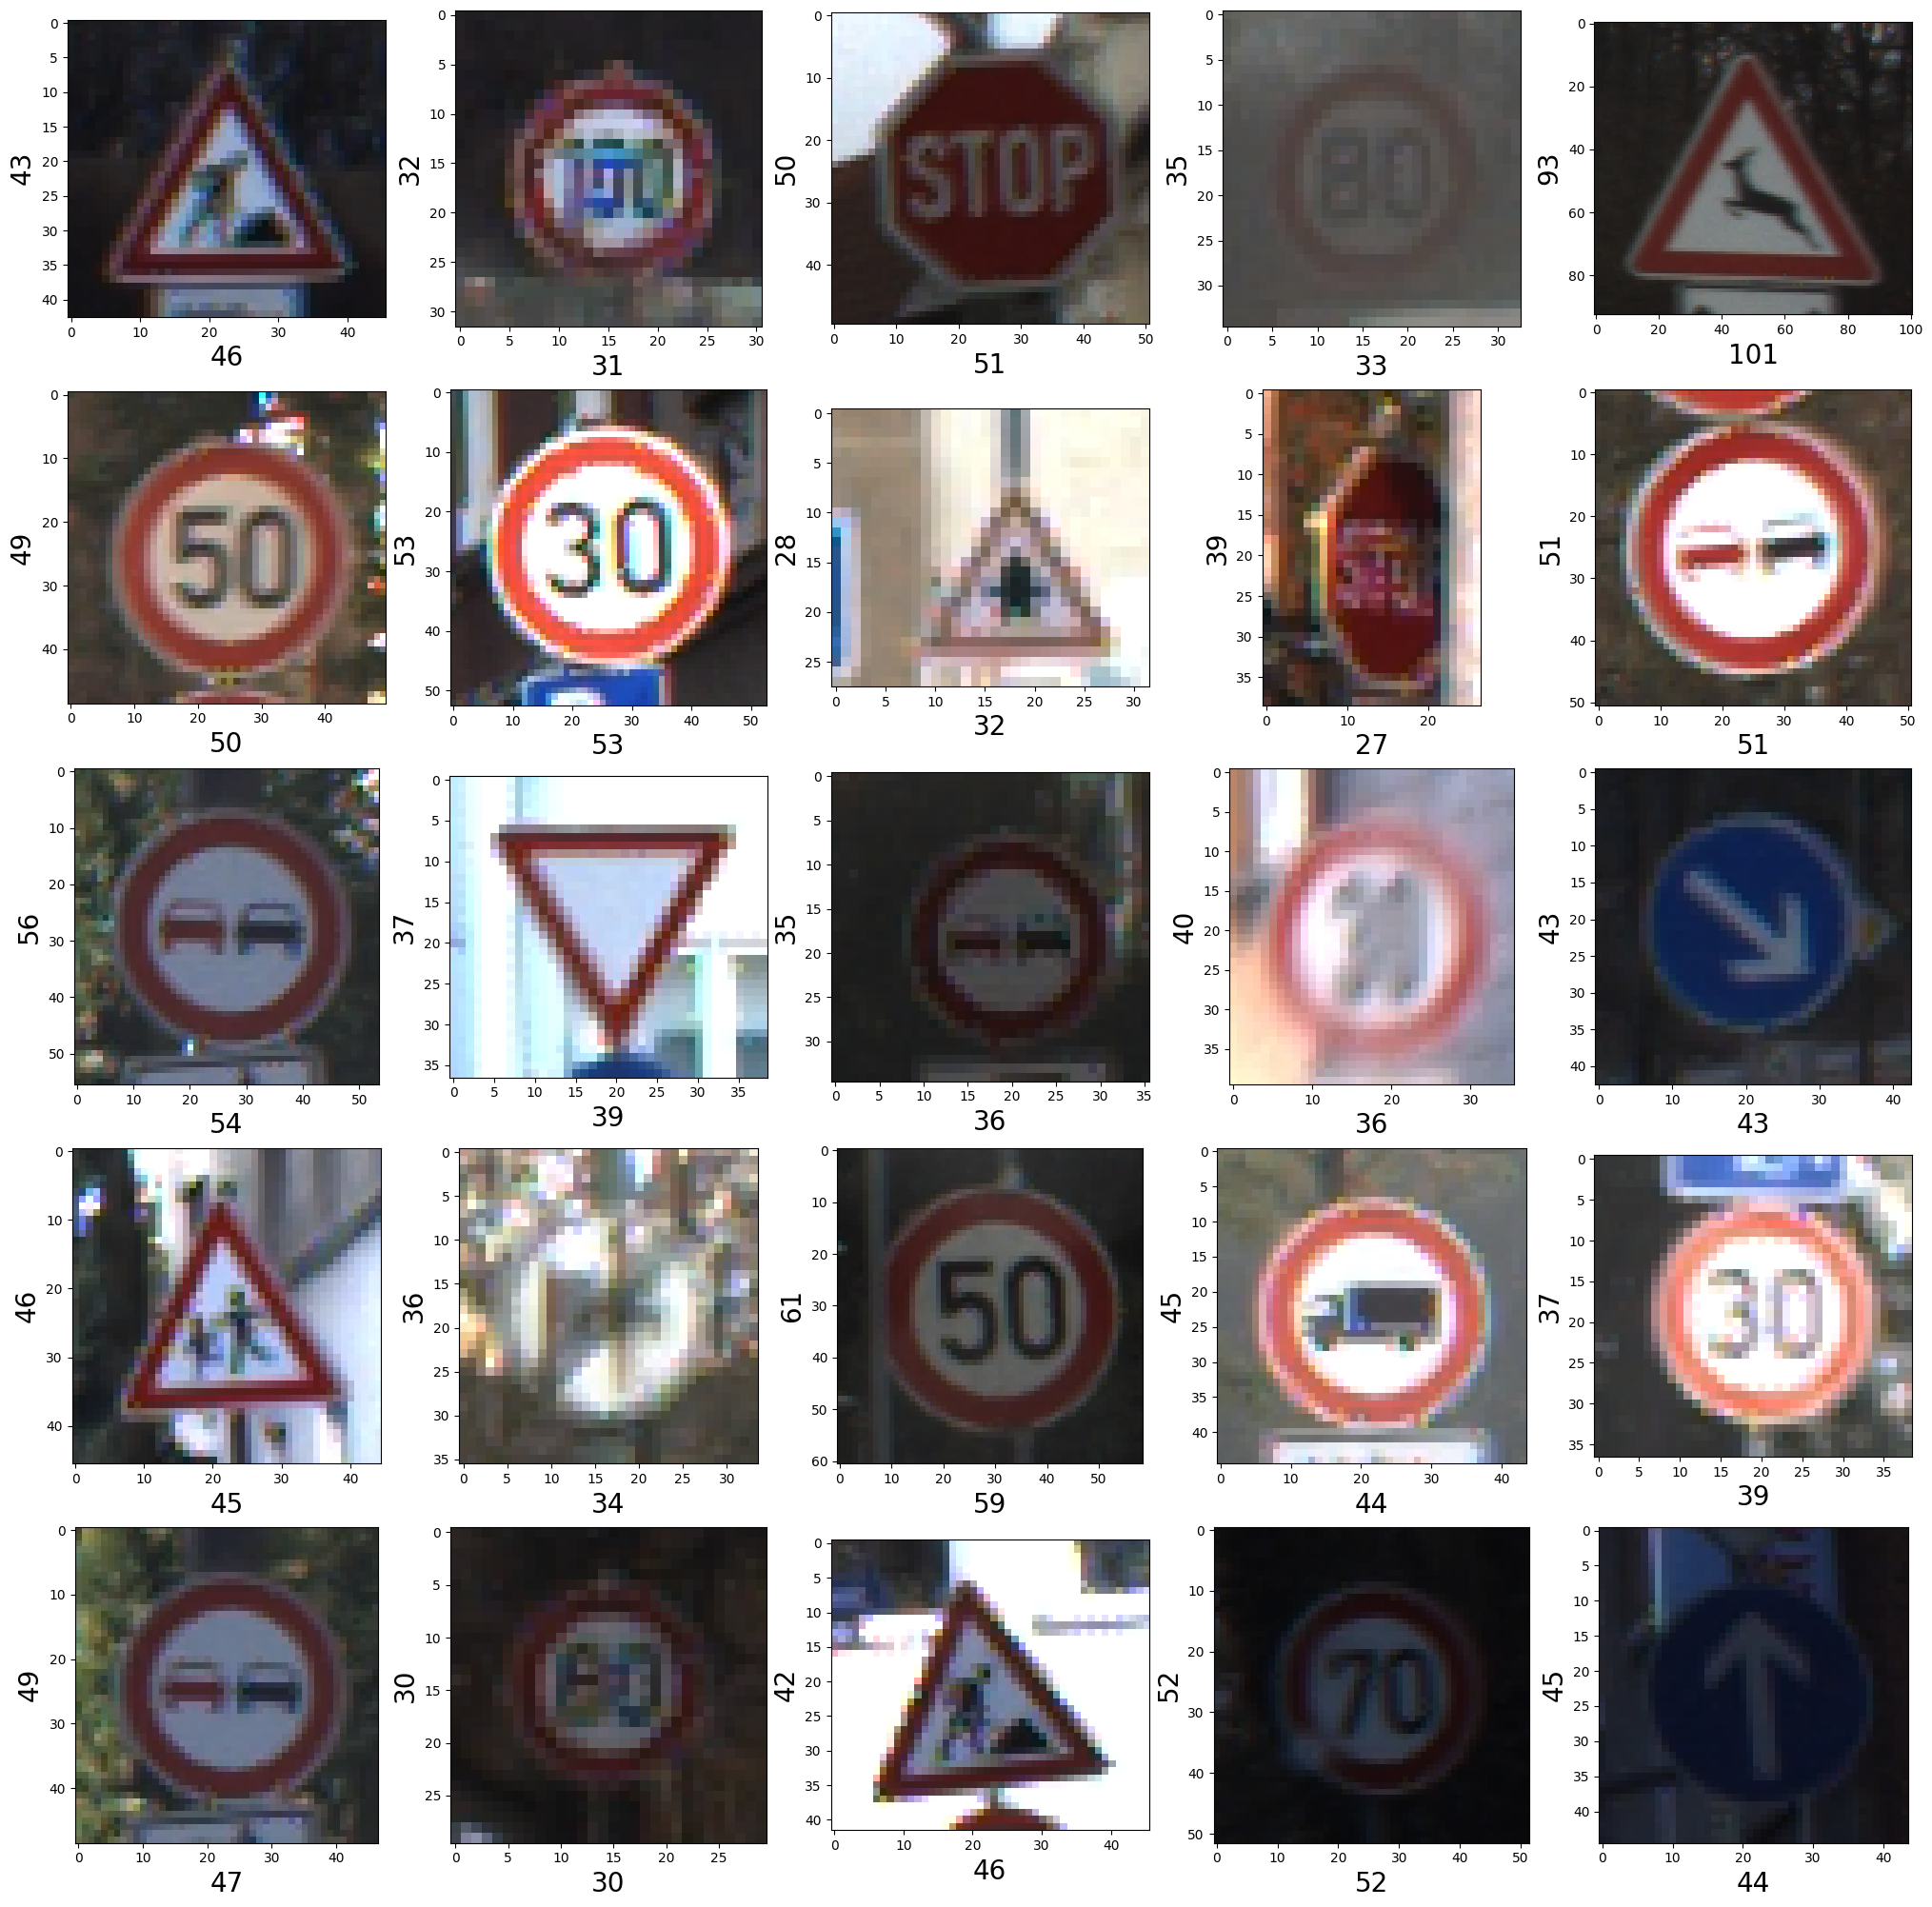

In [7]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(visible=0)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [11]:
def load_data(data_dir, img_size=(30, 30), num_categories=NUM_CATEGORIES):
    images = []
    labels = []
    
    for category in range(num_categories):
        category_dir = os.path.join(data_dir, str(category))
        
        # Check if the directory exists
        if not os.path.exists(category_dir):
            print(f"Directory {category_dir} does not exist. Skipping.")
            continue
        
        for img_name in os.listdir(category_dir):
            img_path = os.path.join(category_dir, img_name)
            
            # Ensure the file is an image
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            
            try:
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(category)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue
    
    return np.array(images), np.array(labels)

In [9]:
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from PIL import Image
from tensorflow.keras.optimizers import Adam


%matplotlib inline

In [12]:
images, labels = load_data(train_path)

# One hot encoding the labels
labels = to_categorical(labels)

# Splitting the dataset into training and test set
x_train, x_test, y_train, y_test = train_test_split(
                                                    np.array(images),
                                                    labels,
                                                    test_size=0.2 , 
                                                    random_state=42, 
                                                    shuffle=True
                                                    )

Directory ./Train/43 does not exist. Skipping.


In [13]:
print("X_train.shape", x_train.shape)
print("X_valid.shape", x_test.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_test.shape)

X_train.shape (31367, 30, 30, 3)
X_valid.shape (7842, 30, 30, 3)
y_train.shape (31367, 43)
y_valid.shape (7842, 43)


In [15]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), activation="relu", input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation="softmax"))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
imgs_path = "./Train"
data_list = []
labels_list = []
classes_list = 43
for i in range(classes_list):
    i_path = os.path.join(imgs_path, str(i)) #0-42
    for img in os.listdir(i_path):
        im = Image.open(i_path +'/'+ img)
        im = im.resize((30,30))
        im = np.array(im)
        data_list.append(im)
        labels_list.append(i)
data = np.array(data_list)
labels = np.array(labels_list)
print(data)

[[[[186 164 164]
   [172 127 106]
   [172 119  85]
   ...
   [179 122  88]
   [182 130  93]
   [182 127  94]]

  [[173 151 137]
   [160 114  89]
   [166 116  84]
   ...
   [168 122  89]
   [168 126  93]
   [167 124  94]]

  [[178 155 148]
   [176 148 135]
   [181 146 136]
   ...
   [171 158 149]
   [173 159 149]
   [174 161 151]]

  ...

  [[ 91  94 100]
   [ 91  92  95]
   [ 91  94  90]
   ...
   [101 100  96]
   [107 101  98]
   [110 102  97]]

  [[ 99 100 105]
   [ 97  98  98]
   [ 96 100  98]
   ...
   [100 101  94]
   [107 106 102]
   [117 112 107]]

  [[102 105 100]
   [104 106 101]
   [102 102 100]
   ...
   [103 102  98]
   [106 108 104]
   [108 109 106]]]


 [[[133 150  86]
   [122 142  75]
   [118 139  74]
   ...
   [109 119  72]
   [104 109  67]
   [111 111  77]]

  [[117 137  75]
   [123 144  77]
   [125 143  80]
   ...
   [107 119  69]
   [101 108  63]
   [100 102  64]]

  [[108 131  73]
   [114 136  76]
   [114 132  78]
   ...
   [115 125  75]
   [105 117  68]
   [ 99 114

In [17]:
def prep_dataset(X,y):
    X_prep = X.astype('float32')
    y_prep = to_categorical(np.array(y))
    return (X_prep, y_prep)

X, y = prep_dataset(data,labels)

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(X,y, test_size=0.2, shuffle=True,stratify=y)
X_val, X_test, Y_val, Y_test = train_test_split(X_val,Y_val, test_size=0.5, shuffle=True)

In [87]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history= model.fit(X_train,Y_train,
                 epochs=15,
                 batch_size=64,
                 validation_data=(X_val,Y_val))

Epoch 1/15
491/491 [==============================] - 14s 28ms/step - loss: 2.0363 - accuracy: 0.5953 - val_loss: 0.1953 - val_accuracy: 0.9587
Epoch 2/15
491/491 [==============================] - 13s 27ms/step - loss: 0.3447 - accuracy: 0.9012 - val_loss: 0.0906 - val_accuracy: 0.9799
Epoch 3/15
491/491 [==============================] - 13s 27ms/step - loss: 0.2020 - accuracy: 0.9431 - val_loss: 0.0553 - val_accuracy: 0.9867
Epoch 4/15
491/491 [==============================] - 13s 27ms/step - loss: 0.1443 - accuracy: 0.9572 - val_loss: 0.0428 - val_accuracy: 0.9893
Epoch 5/15
491/491 [==============================] - 13s 27ms/step - loss: 0.1109 - accuracy: 0.9683 - val_loss: 0.0424 - val_accuracy: 0.9906
Epoch 6/15
491/491 [==============================] - 14s 28ms/step - loss: 0.1076 - accuracy: 0.9706 - val_loss: 0.0355 - val_accuracy: 0.9939
Epoch 7/15
491/491 [==============================] - 13s 26ms/step - loss: 0.0850 - accuracy: 0.9762 - val_loss: 0.0410 - val_accuracy:

In [88]:
model.save("trafficsign.h5")

/Users/jay/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Figure(1200x1000)
[<Axes: title={'center': 'Accuracy'}> <Axes: title={'center': 'Loss'}>]


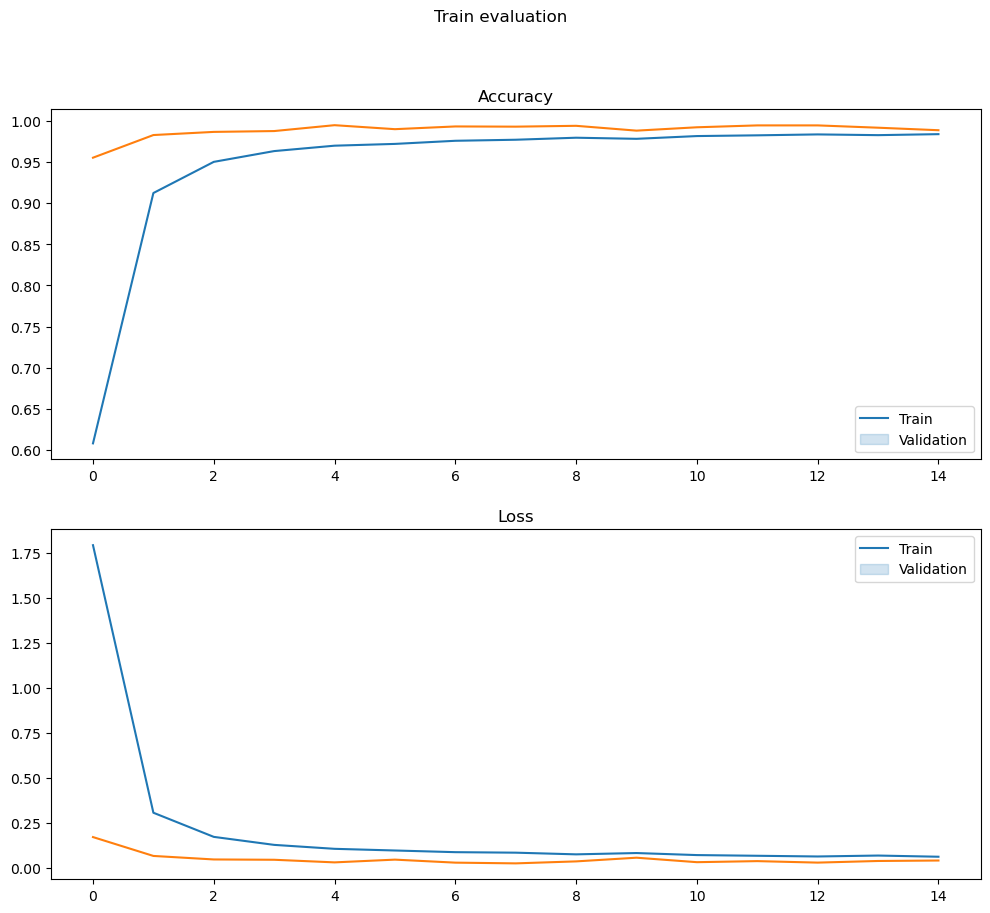

In [15]:
import seaborn as sns
fig,ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
print(fig)
print(ax)

In [16]:
loss, accuracy = model.evaluate(x_test, y_test)

print('test set accuracy: ', accuracy * 100)

246/246 [==============================] - 1s 5ms/step - loss: 0.0479 - accuracy: 0.9869
test set accuracy:  98.68655800819397


In [17]:
# Testing accuracy on the test dataset
from sklearn.metrics import accuracy_score
import pandas as pd
from PIL import Image
import numpy as np

# Load the test labels and filenames
test_data = pd.read_csv('./Test.csv')
labels = test_data["ClassId"].values
filenames = test_data["Path"].values  # Use the actual column name from your CSV

data = []

# Load and preprocess test images
for filename in filenames:
    img_path = os.path.join('./', filename)  # Adjust the path as needed
    image = Image.open(img_path)
    image = image.resize((30, 30))
    data.append(np.array(image))

X_test = np.array(data)

# Predict probabilities for each class
pred_probs = model.predict(X_test)

# Find the class with the highest probability for each sample
pred = np.argmax(pred_probs, axis=1)

# Calculate accuracy with the test data
accuracy = accuracy_score(labels, pred)
print("Test accuracy:", accuracy)

395/395 [==============================] - 2s 5ms/step
Test accuracy: 0.9742676167854315


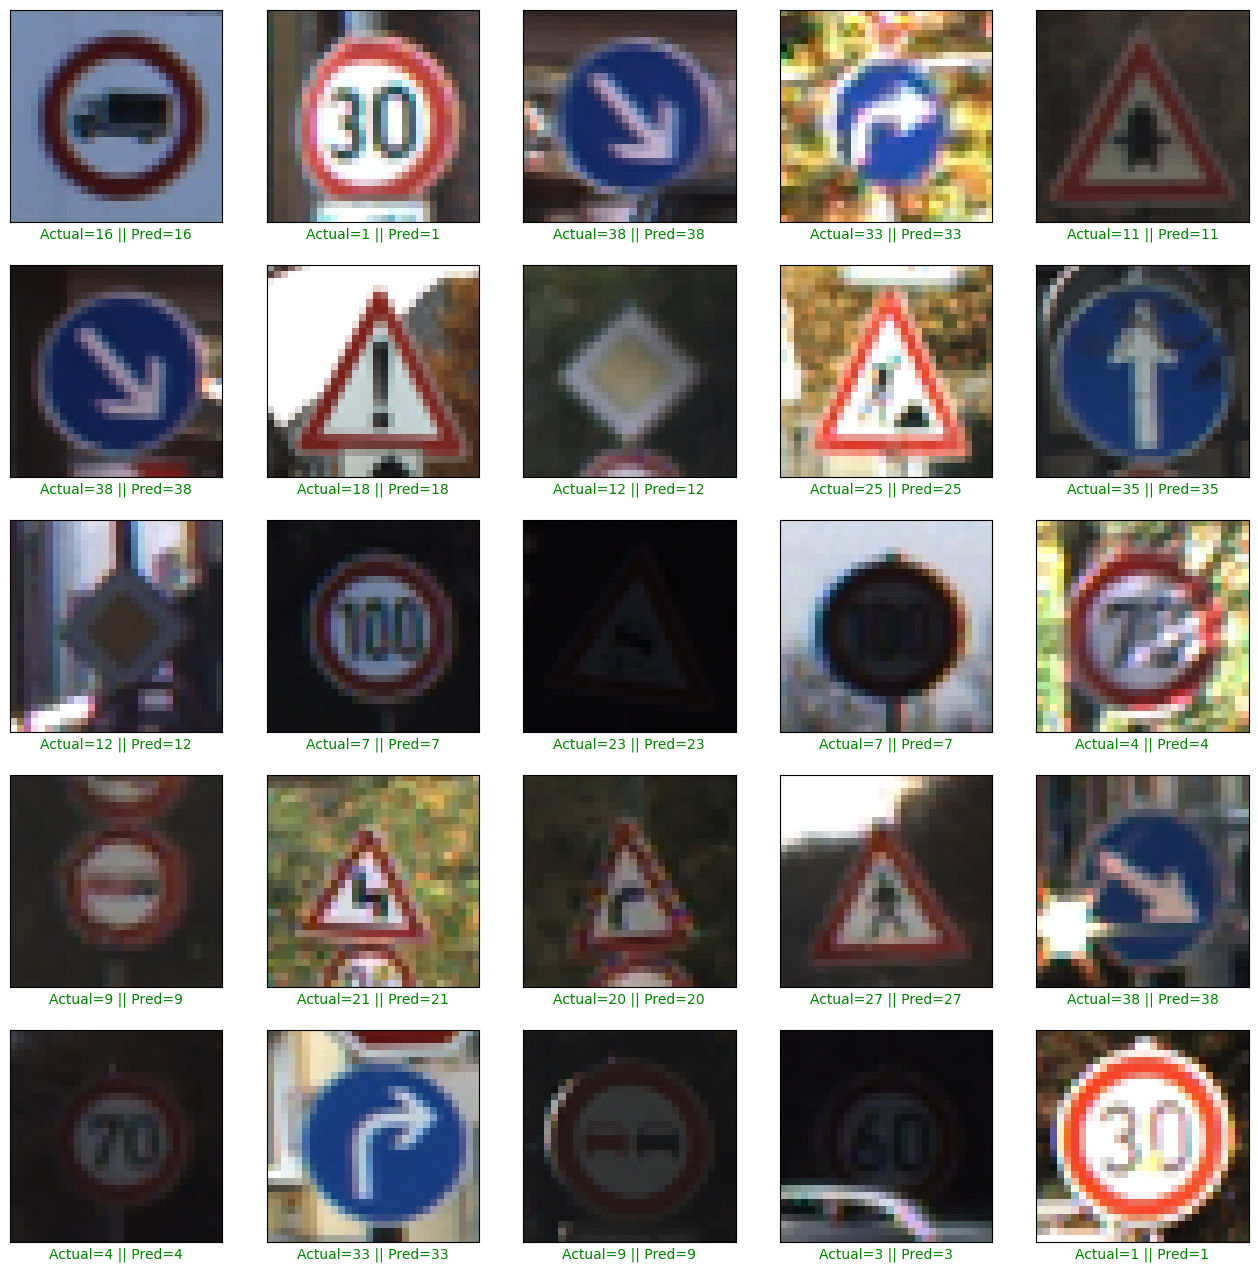

In [18]:
plt.figure(figsize = (16, 16))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()



In [24]:
from sklearn.model_selection import train_test_split

# Split the data consistently for both CNN and RCNN
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
X_val_cnn, X_test_cnn, y_val_cnn, y_test_cnn = train_test_split(X_test_cnn, y_test_cnn, test_size=0.5, random_state=42, shuffle=True, stratify=y_test_cnn)

# Reshape data for RCNN
X_train_rcnn = X_train_cnn.reshape(-1, 1, 30, 30, 3)
X_val_rcnn = X_val_cnn.reshape(-1, 1, 30, 30, 3)
X_test_rcnn = X_test_cnn.reshape(-1, 1, 30, 30, 3)

# Build RCNN model
model_rcnn = Sequential()
model_rcnn.add(TimeDistributed(Conv2D(filters=16, kernel_size=(3,3), activation="relu"), input_shape=(1, 30, 30, 3)))
model_rcnn.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3,3), activation="relu")))
model_rcnn.add(TimeDistributed(MaxPool2D(pool_size=(2,2))))
model_rcnn.add(TimeDistributed(Dropout(rate=0.25)))
model_rcnn.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3,3), activation="relu")))
model_rcnn.add(TimeDistributed(Conv2D(filters=128, kernel_size=(3,3), activation="relu")))
model_rcnn.add(TimeDistributed(MaxPool2D(pool_size=(2,2))))
model_rcnn.add(TimeDistributed(Dropout(rate=0.25)))
model_rcnn.add(TimeDistributed(Flatten()))
model_rcnn.add(LSTM(128, return_sequences=False))
model_rcnn.add(Dense(512, activation="relu"))
model_rcnn.add(Dropout(rate=0.5))
model_rcnn.add(Dense(43, activation="softmax"))

# Compile RCNN model
model_rcnn.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Train RCNN model
history_rcnn = model_rcnn.fit(X_train_rcnn, y_train_cnn,
                    epochs=15,
                    batch_size=64,
                    validation_data=(X_val_rcnn, y_val_cnn))

# Evaluate RCNN model
rcnn_scores = model_rcnn.evaluate(X_test_rcnn, y_test_cnn, verbose=0)
print("RCNN Test Loss:", rcnn_scores[0])
print("RCNN Test Accuracy:", rcnn_scores[1])


Epoch 1/15
491/491 [==============================] - 15s 28ms/step - loss: 3.5204 - accuracy: 0.0530 - val_loss: 3.4937 - val_accuracy: 0.0574
Epoch 2/15
491/491 [==============================] - 14s 28ms/step - loss: 3.5024 - accuracy: 0.0541 - val_loss: 3.4889 - val_accuracy: 0.0574
Epoch 3/15
491/491 [==============================] - 14s 28ms/step - loss: 3.4988 - accuracy: 0.0562 - val_loss: 3.4914 - val_accuracy: 0.0528
Epoch 4/15
491/491 [==============================] - 14s 28ms/step - loss: 3.4997 - accuracy: 0.0557 - val_loss: 3.4879 - val_accuracy: 0.0566
Epoch 5/15
491/491 [==============================] - 14s 28ms/step - loss: 3.5001 - accuracy: 0.0551 - val_loss: 3.4881 - val_accuracy: 0.0551
Epoch 6/15
491/491 [==============================] - 14s 29ms/step - loss: 3.4992 - accuracy: 0.0569 - val_loss: 3.4874 - val_accuracy: 0.0566
Epoch 7/15
491/491 [==============================] - 14s 29ms/step - loss: 3.4974 - accuracy: 0.0540 - val_loss: 3.4870 - val_accuracy:

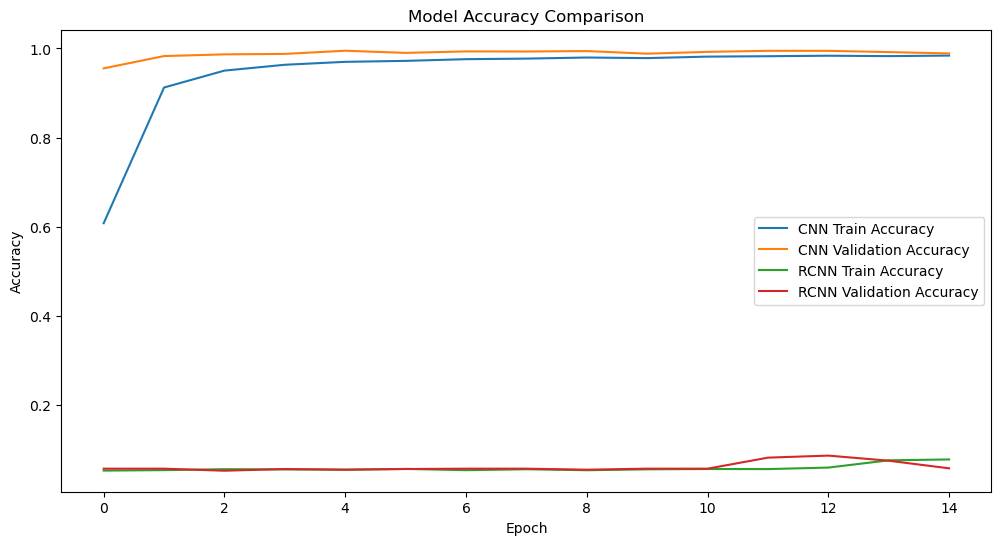

In [25]:
import matplotlib.pyplot as plt

# Compare training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='CNN Train Accuracy')
plt.plot(history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.plot(history_rcnn.history['accuracy'], label='RCNN Train Accuracy')
plt.plot(history_rcnn.history['val_accuracy'], label='RCNN Validation Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

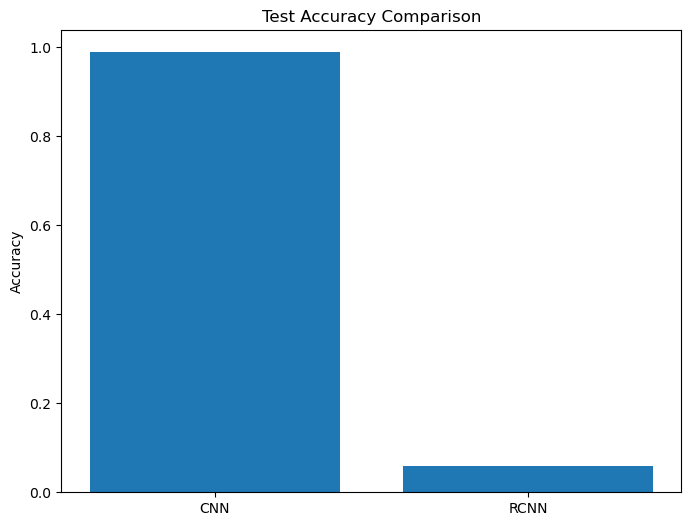

In [26]:
# Compare test accuracy
plt.figure(figsize=(8, 6))
plt.bar(['CNN', 'RCNN'], [history.history['val_accuracy'][-1], history_rcnn.history['val_accuracy'][-1]])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

In [32]:
from tensorflow.keras.layers import TimeDistributed, LSTM

# Build updated RCNN model
model_rcnn_updated = Sequential()
model_rcnn_updated.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3,3), activation="relu"), input_shape=(1, 30, 30, 3)))
model_rcnn_updated.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3,3), activation="relu")))
model_rcnn_updated.add(TimeDistributed(MaxPool2D(pool_size=(2,2))))
model_rcnn_updated.add(TimeDistributed(Dropout(rate=0.25)))
model_rcnn_updated.add(TimeDistributed(Conv2D(filters=128, kernel_size=(3,3), activation="relu")))
model_rcnn_updated.add(TimeDistributed(Conv2D(filters=256, kernel_size=(3,3), activation="relu")))
model_rcnn_updated.add(TimeDistributed(MaxPool2D(pool_size=(2,2))))
model_rcnn_updated.add(TimeDistributed(Dropout(rate=0.25)))
model_rcnn_updated.add(TimeDistributed(Flatten()))
model_rcnn_updated.add(LSTM(256, return_sequences=False))
model_rcnn_updated.add(Dense(512, activation="relu"))
model_rcnn_updated.add(Dropout(rate=0.5))
model_rcnn_updated.add(Dense(43, activation="softmax"))

# Compile updated RCNN model
model_rcnn_updated.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Train updated RCNN model
history_rcnn_updated = model_rcnn_updated.fit(X_train_rcnn, y_train_cnn,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_val_rcnn, y_val_cnn))

# Evaluate updated RCNN model
rcnn_scores_updated = model_rcnn_updated.evaluate(X_test_rcnn, y_test_cnn, verbose=0)
print("Updated RCNN Test Loss:", rcnn_scores_updated[0])
print("Updated RCNN Test Accuracy:", rcnn_scores_updated[1])


Epoch 1/50
246/246 [==============================] - 36s 144ms/step - loss: 3.5277 - accuracy: 0.0544 - val_loss: 3.4943 - val_accuracy: 0.0574
Epoch 2/50
246/246 [==============================] - 36s 146ms/step - loss: 3.5078 - accuracy: 0.0538 - val_loss: 3.4895 - val_accuracy: 0.0536
Epoch 3/50
246/246 [==============================] - 37s 150ms/step - loss: 3.5026 - accuracy: 0.0554 - val_loss: 3.4915 - val_accuracy: 0.0566
Epoch 4/50
246/246 [==============================] - 37s 152ms/step - loss: 3.5009 - accuracy: 0.0543 - val_loss: 3.4868 - val_accuracy: 0.0536
Epoch 5/50
246/246 [==============================] - 38s 155ms/step - loss: 3.4990 - accuracy: 0.0537 - val_loss: 3.4887 - val_accuracy: 0.0574
Epoch 6/50
246/246 [==============================] - 40s 163ms/step - loss: 3.4970 - accuracy: 0.0550 - val_loss: 3.4876 - val_accuracy: 0.0566
Epoch 7/50
246/246 [==============================] - 45s 182ms/step - loss: 3.5055 - accuracy: 0.0532 - val_loss: 3.4870 - val_ac

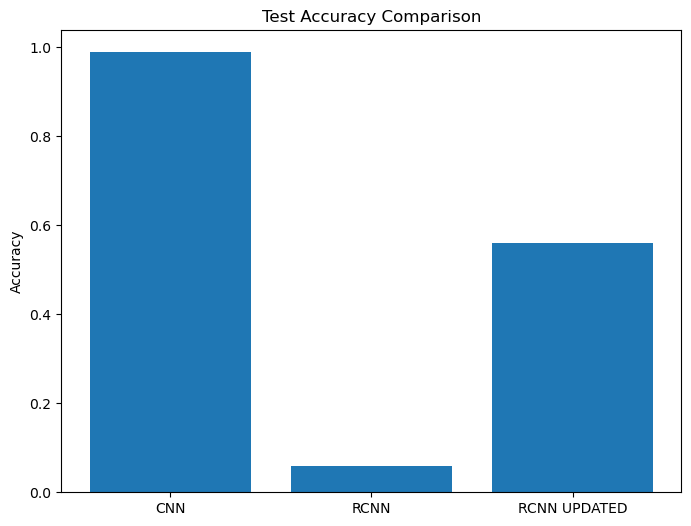

In [33]:


plt.figure(figsize=(8, 6))
plt.bar(['CNN', 'RCNN','RCNN UPDATED'], [history.history['val_accuracy'][-1], history_rcnn.history['val_accuracy'][-1],history_rcnn_updated.history['val_accuracy'][-1]])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

In [23]:
from tensorflow.keras.layers import LeakyReLU
from sklearn.model_selection import train_test_split

# Split the data consistently for both CNN and RCNN
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
X_val_cnn, X_test_cnn, y_val_cnn, y_test_cnn = train_test_split(X_test_cnn, y_test_cnn, test_size=0.5, random_state=42, shuffle=True, stratify=y_test_cnn)

# Reshape data for RCNN
X_train_rcnn = X_train_cnn.reshape(-1, 1, 30, 30, 3)
X_val_rcnn = X_val_cnn.reshape(-1, 1, 30, 30, 3)
X_test_rcnn = X_test_cnn.reshape(-1, 1, 30, 30, 3)
# Build updated RCNN model with LeakyReLU activation
model_rcnn_updated = Sequential()
model_rcnn_updated.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3,3))))
model_rcnn_updated.add(LeakyReLU(alpha=0.1))
model_rcnn_updated.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3,3))))
model_rcnn_updated.add(LeakyReLU(alpha=0.1))
model_rcnn_updated.add(TimeDistributed(MaxPool2D(pool_size=(2,2))))
model_rcnn_updated.add(TimeDistributed(Dropout(rate=0.25)))
model_rcnn_updated.add(TimeDistributed(Conv2D(filters=128, kernel_size=(3,3))))
model_rcnn_updated.add(LeakyReLU(alpha=0.1))
model_rcnn_updated.add(TimeDistributed(Conv2D(filters=256, kernel_size=(3,3))))
model_rcnn_updated.add(LeakyReLU(alpha=0.1))
model_rcnn_updated.add(TimeDistributed(MaxPool2D(pool_size=(2,2))))
model_rcnn_updated.add(TimeDistributed(Dropout(rate=0.25)))
model_rcnn_updated.add(TimeDistributed(Flatten()))
model_rcnn_updated.add(LSTM(256, return_sequences=False))
model_rcnn_updated.add(Dense(512))
model_rcnn_updated.add(LeakyReLU(alpha=0.1))
model_rcnn_updated.add(Dropout(rate=0.5))
model_rcnn_updated.add(Dense(43, activation="softmax"))

# Compile updated RCNN model
model_rcnn_updated.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Train updated RCNN model
history_rcnn_updated = model_rcnn_updated.fit(X_train_rcnn, y_train_cnn,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_val_rcnn, y_val_cnn))

# Evaluate updated RCNN model
rcnn_scores_updated = model_rcnn_updated.evaluate(X_test_rcnn, y_test_cnn, verbose=0)
print("Updated RCNN Test Loss:", rcnn_scores_updated[0])
print("Updated RCNN Test Accuracy:", rcnn_scores_updated[1])


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


246/246 ━━━━━━━━━━━━━━━━━━━━ 45s 169ms/step - accuracy: 0.0484 - loss: 3.5580 - val_accuracy: 0.0528 - val_loss: 3.4949
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 43s 176ms/step - accuracy: 0.0555 - loss: 3.5042 - val_accuracy: 0.0566 - val_loss: 3.5061
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 45s 182ms/step - accuracy: 0.0563 - loss: 3.5061 - val_accuracy: 0.0513 - val_loss: 3.4910
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 44s 180ms/step - accuracy: 0.0553 - loss: 3.4971 - val_accuracy: 0.0566 - val_loss: 3.4910
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 48s 194ms/step - accuracy: 0.0545 - loss: 3.4930 - val_accuracy: 0.0551 - val_loss: 3.4892
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 45s 182ms/step - accuracy: 0.0524 - loss: 3.4986 - val_accuracy: 0.0566 - val_loss: 3.4887
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 48s 194ms/step - accuracy: 0.0519 - loss: 3.4926 - val_accuracy: 0.0551 - val_loss: 3.4893
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 52s 211ms/step - accuracy: 0.0573 - loss: 3.4960 - val